In [4]:
!pip install gymnasium
!pip install gymnasium[toy_text]

In [5]:
import gymnasium as gym
import numpy as np

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


1. CREATE THE ENVIRONMENT

In [6]:
# Taxi-v3 is a classic discrete environment where:
# - The taxi must pick up a passenger at one location
# - Drop them off at another location
# - Avoid illegal moves and minimize steps

env = gym.make("Taxi-v3")

In [7]:
# Number of possible states and actions

n_states = env.observation_space.n  # e.g. 500
n_actions = env.action_space.n # e.g. 6

2. INITIALIZE Q-TABLE

In [8]:
# Q-table shape: [num_states x num_actions]
# Q[s, a] will store the estimated value of taking action a in state s

Q = np.zeros((n_states, n_actions))

3. HYPERPARAMETERS

In [10]:
alpha = 0.1 # Learning rate: how much new info overrides old info
gamma = 0.99 # Discount factor: importance of future rewards
epsilon = 1.0 # Initial exploration rate (start very exploratory)
epsilon_min = 0.05 # Minimum exploration (we always keep some randomness)
epsilon_decay = 0.999 # How fast epsilon decays per episode
episodes = 5000 # Number of training episodes

# For tracking progress (optional)
reward_history = []


4. TRAINING LOOP

In [13]:
for ep in range(episodes):
  # env.reset() in Gymnasium returns (observation, info)
  state, info = env.reset()
  done = False
  total_reward = 0

  while not done:
    # Epsilon-greedy policy
    # With probability epsilon: choose randon action (explore)
    # Otherwise: choose best known action (exploit)
    if np.random.random() < epsilon:
      action = np.argmax(Q[state]) # Best action from Q-table for this state

    # Take the action in the environment
    # Gymnasium step() returns:
    # next_step, reward, terminated, truncated, info
    # done = terminated (natural end) OR truncated (time limit / interrupt)

    next_state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    # Q-learning updated rule:
    # Q(s,a) <- Q(s,a) + α [ r + γ max_a' Q(s', a') − Q(s,a) ]

    best_next_action = np.max(Q[next_state]) # max over a' Q(s', a')
    td_target = reward + gamma * best_next_action
    td_error = td_target - Q[state, action]
    Q[state, action] = Q[state, action] + alpha * td_error

    # Move to next state
    state = next_state
    total_reward += reward

  # Decay epsilon after each episode (gradually reduce exploration)

  epsilon = max(epsilon_min, epsilon * epsilon_decay)

  reward_history.append(total_reward)

  # Print occasional progress
  if (ep + 1) % 500 == 0:
    avg_last_500 = np.mean(reward_history[-500:])
    print(f"Episode {ep+1}/{episodes} - Avg reward (last 500): {avg_last_500:.2f}, epsilon: {epsilon:.3f}")

print("Trainig complete!")


Episode 500/5000 - Avg reward (last 500): -188.13, epsilon: 0.606
Episode 1000/5000 - Avg reward (last 500): -62.70, epsilon: 0.368
Episode 1500/5000 - Avg reward (last 500): -80.46, epsilon: 0.223
Episode 2000/5000 - Avg reward (last 500): -153.79, epsilon: 0.135
Episode 2500/5000 - Avg reward (last 500): -238.22, epsilon: 0.082
Episode 3000/5000 - Avg reward (last 500): -291.18, epsilon: 0.050
Episode 3500/5000 - Avg reward (last 500): -335.86, epsilon: 0.050
Episode 4000/5000 - Avg reward (last 500): -328.17, epsilon: 0.050
Episode 4500/5000 - Avg reward (last 500): -344.43, epsilon: 0.050
Episode 5000/5000 - Avg reward (last 500): -326.21, epsilon: 0.050
Trainig complete!


**Test the trained agent**

In [14]:
# Re-create environment with text (ANSI) rendering
# This makes env.render() return a string visualization
env = gym.make("Taxi-v3", render_mode="ansi")

state, info = env.reset()
done = False
total_reward = 0
step_count = 0

print("Running one trained episode:\n")

while not done:
  # Choose the best action according to learned Q-table (pure exploitation)
  action = np.argmax(Q[state])

  # Take action in environment
  next_state, reward, terminated, truncated, info = env.step(action)
  done = terminated or truncated
  total_reward += reward
  step_count += 1

  # Render the environment as text and print it
  frame_str = env.render() # returns a string in ansi mode
  print(frame_str)
  print("-" * 40)

  state = next_state

print("Episode finished in", step_count, "steps with total reward:", total_reward)

Running one trained episode:

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

----------------------------------------
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

----------------------------------------
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

----------------------------------------
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)

----------------------------------------
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

----------------------------------------
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)

----------------------------------------
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)

----------------------------------------
+---------+
|R: | : :

**Quick Sanity Check**

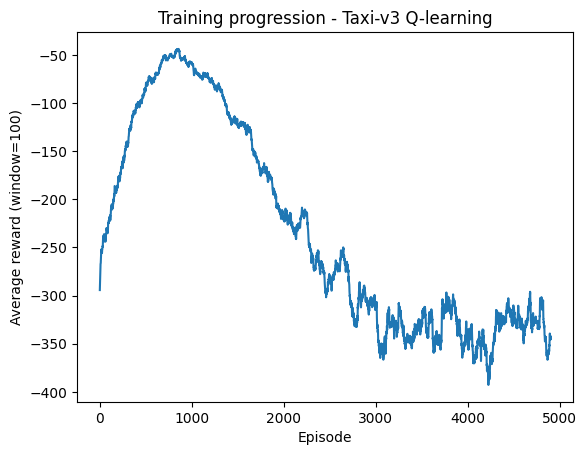

In [15]:
import matplotlib.pyplot as plt

# Simple moving average over window of 100 episodes
window = 100

if len(reward_history) >= window:
  moving_avg = np.convolve(reward_history, np.ones(window)/window, mode='valid')
  plt.plot(moving_avg)
  plt.xlabel("Episode")
  plt.ylabel(f"Average reward (window={window})")
  plt.title("Training progression - Taxi-v3 Q-learning")
  plt.show()
else:
  print("Not enough episodes to plot moving average.")